<a href="https://colab.research.google.com/github/PacktPublishing/Modern-Computer-Vision-with-PyTorch-2E/blob/main/Chapter06/Road_sign_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('GTSRB'):
    %pip install -U -q torch_snippets
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
    !wget -qq https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
    !unzip -qq GTSRB_Final_Training_Images.zip
    !unzip -qq GTSRB_Final_Test_Images.zip
    !wget https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
    !rm GTSRB_Final_Training_Images.zip GTSRB_Final_Test_Images.zip

In [ ]:
import pandas as pd                                 # Explicitly import pandas as it is used
import torch                                        # Explicitly import torch
from torch import nn, optim                         # Explicitly import nn and optim from torch
from torch.utils.data import Dataset, DataLoader    # Import Dataset and DataLoader
import numpy as np                                  # Explicitly import numpy as it is used
from torchvision import transforms as T
from sklearn.model_selection import train_test_split # Explicitly import train_test_split

from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2),
    # contrast=(0.8,1.2),
    # saturation=(0.8,1.2),
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        try:
            fpath = self.files[ix]
            clss = fname(parent(fpath))
            img = read(fpath, 1)
            return img, classIds[clss]
        except:
            Warn(f'Missing {fpath}. Loading a different image')
            return self[randint(len(self))]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        #nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

# Manual logging
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for ex in range(n_epochs):
    tr_loss, tr_acc = [], []
    for data in trn_dl:
        loss, acc = train_batch(model, data, optimizer, criterion)
        tr_loss.append(loss)
        tr_acc.append(acc)

    avg_tr_loss = sum(tr_loss) / len(tr_loss)
    avg_tr_acc = sum(tr_acc) / len(tr_acc)
    train_losses.append(avg_tr_loss)
    train_accs.append(avg_tr_acc)

    val_loss, val_acc = [], []
    for data in val_dl:
        loss, acc = validate_batch(model, data, criterion)
        val_loss.append(loss)
        val_acc.append(acc)

    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_val_acc = sum(val_acc) / len(val_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"Epoch {ex+1}/{n_epochs} | "
          f"Train Loss: {avg_tr_loss:.4f}, Acc: {avg_tr_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

    if ex == 10:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Saving the logs to a file within the same block
import dill # Ensure dill is imported
with open("no-aug-no-bn.log", "wb") as f:
    dill.dump({
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }, f)

[06/01/25 01:24:05] INFO     29406                                                                                                ]8;id=561406;file://<ipython-input-2-0317051db02b>:54\<ipython-input-2-0317051db02b>]8;;\:]8;id=617745;file://<ipython-input-2-0317051db02b>:54#__init__:54\__init__:54]8;;\

                    INFO     9803                                                                                                 ]8;id=573795;file://<ipython-input-2-0317051db02b>:54\<ipython-input-2-0317051db02b>]8;;\:]8;id=64792;file://<ipython-input-2-0317051db02b>:54#__init__:54\__init__:54]8;;\

Epoch 1/40 | Train Loss: 2.3407, Acc: 0.3145 | Val Loss: 1.3297, Acc: 0.5718
Epoch 2/40 | Train Loss: 0.9752, Acc: 0.6820 | Val Loss: 0.7554, Acc: 0.7506


In [ ]:
import os
import dill
import matplotlib.pyplot as plt
from torch_snippets import Glob

# Plotting manual logger
def plot_log_metrics(log_data, title="Log"):
    epochs = list(range(1, len(log_data['train_accs']) + 1))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, log_data['train_accs'], label='Train Accuracy', color='green')
    plt.plot(epochs, log_data['val_accs'], label='Val Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)

# Loop file .log
for fname in Glob('*.log'):
    with open(fname, 'rb') as f:
        log_data = dill.load(f)

    plot_log_metrics(log_data, title=str(fname).replace('.log', ''))

In [ ]:
import pandas as pd                                 # Explicitly import pandas as it is used
import torch                                        # Explicitly import torch
from torch import nn, optim                         # Explicitly import nn and optim from torch
from torch.utils.data import Dataset, DataLoader    # Import Dataset and DataLoader
import numpy as np                                  # Explicitly import numpy as it is used
from torchvision import transforms as T
from sklearn.model_selection import train_test_split # Explicitly import train_test_split

from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    # T.ColorJitter(brightness=(0.8,1.2),
    # contrast=(0.8,1.2),
    # saturation=(0.8,1.2),
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        try:
            fpath = self.files[ix]
            clss = fname(parent(fpath))
            img = read(fpath, 1)
            return img, classIds[clss]
        except:
            Warn(f'Missing {fpath}. Loading a different image')
            return self[randint(len(self))]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

# Manual logging
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for ex in range(n_epochs):
    tr_loss, tr_acc = [], []
    for data in trn_dl:
        loss, acc = train_batch(model, data, optimizer, criterion)
        tr_loss.append(loss)
        tr_acc.append(acc)

    avg_tr_loss = sum(tr_loss) / len(tr_loss)
    avg_tr_acc = sum(tr_acc) / len(tr_acc)
    train_losses.append(avg_tr_loss)
    train_accs.append(avg_tr_acc)

    val_loss, val_acc = [], []
    for data in val_dl:
        loss, acc = validate_batch(model, data, criterion)
        val_loss.append(loss)
        val_acc.append(acc)

    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_val_acc = sum(val_acc) / len(val_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"Epoch {ex+1}/{n_epochs} | "
          f"Train Loss: {avg_tr_loss:.4f}, Acc: {avg_tr_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

    if ex == 10:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

import dill
with open("no-aug-yes-bn.log", "wb") as f:
    dill.dump({
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }, f)

[06/01/25 02:01:34] INFO     29406                                                                                                ]8;id=560996;file://<ipython-input-4-e215f34b4473>:54\<ipython-input-4-e215f34b4473>]8;;\:]8;id=969276;file://<ipython-input-4-e215f34b4473>:54#__init__:54\__init__:54]8;;\

                    INFO     9803                                                                                                 ]8;id=474328;file://<ipython-input-4-e215f34b4473>:54\<ipython-input-4-e215f34b4473>]8;;\:]8;id=597279;file://<ipython-input-4-e215f34b4473>:54#__init__:54\__init__:54]8;;\

Epoch 1/40 | Train Loss: 1.4123, Acc: 0.5794 | Val Loss: 0.5772, Acc: 0.8139
Epoch 2/40 | Train Loss: 0.4400, Acc: 0.8579 | Val Loss: 0.3527, Acc: 0.8856
Epoch 3/40 | Train Loss: 0.2968, Acc: 0.9025 | Val Loss: 0.2930, Acc: 0.9044
Epoch 4/40 | Train Loss: 0.2360, Acc: 0.9226 | Val Loss: 0.2488, Acc: 0.9159
Epoch 5/40 | Train Loss: 0.1935, Acc: 0.9343 | Val Loss: 0.2182, Acc: 0.9270
Epoch 6/40 | Train Loss: 0.1691, Acc: 0.9440 | Val Loss: 0.1612, Acc: 0.9495
Epoch 7/40 | Train Loss: 0.1518, Acc: 0.9488 | Val Loss: 0.1937, Acc: 0.9409
Epoch 8/40 | Train Loss: 0.1332, Acc: 0.9557 | Val Loss: 0.1669, Acc: 0.9458
Epoch 9/40 | Train Loss: 0.1212, Acc: 0.9595 | Val Loss: 0.1384, Acc: 0.9552
Epoch 10/40 | Train Loss: 0.1112, Acc: 0.9619 | Val Loss: 0.1495, Acc: 0.9539
Epoch 11/40 | Train Loss: 0.1033, Acc: 0.9670 | Val Loss: 0.1318, Acc: 0.9617
Epoch 12/40 | Train Loss: 0.0593, Acc: 0.9799 | Val Loss: 0.0874, Acc: 0.9708
Epoch 13/40 | Train Loss: 0.0510, Acc: 0.9826 | Val Loss: 0.0711, Acc: 0.

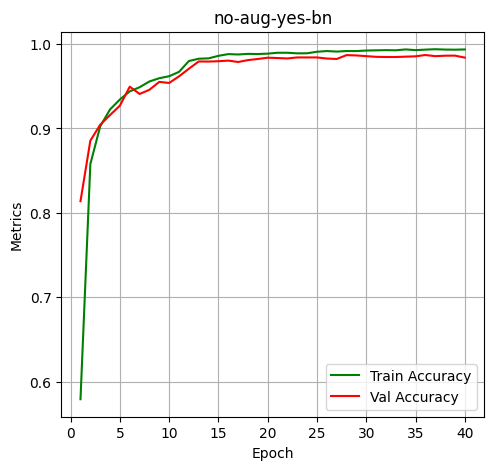

In [ ]:
import os
import dill
import matplotlib.pyplot as plt
from torch_snippets import Glob

def plot_log_metrics(log_data, title="Log"):
    epochs = list(range(1, len(log_data['train_accs']) + 1))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, log_data['train_accs'], label='Train Accuracy', color='green')
    plt.plot(epochs, log_data['val_accs'], label='Val Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)

for fname in Glob('*.log'):
    with open(fname, 'rb') as f:
        log_data = dill.load(f)

    plot_log_metrics(log_data, title=str(fname).replace('.log', ''))

In [ ]:
from torch_snippets import *
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T
classIds = pd.read_csv('signnames.csv')
classIds.set_index('ClassId', inplace=True)
classIds = classIds.to_dict()['SignName']
classIds = {f'{k:05d}':v for k,v in classIds.items()}
id2int = {v:ix for ix,(k,v) in enumerate(classIds.items())}

from torchvision import transforms as T

trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ColorJitter(brightness=(0.8,1.2),
    contrast=(0.8,1.2),
    saturation=(0.8,1.2),
    hue=0.25),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(32),
    T.CenterCrop(32),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class GTSRB(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        try:
            fpath = self.files[ix]
            clss = fname(parent(fpath))
            img = read(fpath, 1)
            return img, classIds[clss]
        except:
            Warn(f'Missing {fpath}. Loading a different image')
            return self[randint(len(self))]

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('GTSRB/Final_Training/Images/*/*.ppm')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = GTSRB(trn_files, transform=trn_tfms)
val_ds = GTSRB(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

import torchvision.models as models

def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class SignClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        ce_loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return ce_loss, acc
def train_batch(model, data, optimizer, criterion):
    ims, labels = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    ims, labels = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()
model = SignClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 40

# Manual logging
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for ex in range(n_epochs):
    tr_loss, tr_acc = [], []
    for data in trn_dl:
        loss, acc = train_batch(model, data, optimizer, criterion)
        tr_loss.append(loss)
        tr_acc.append(acc)

    avg_tr_loss = sum(tr_loss) / len(tr_loss)
    avg_tr_acc = sum(tr_acc) / len(tr_acc)
    train_losses.append(avg_tr_loss)
    train_accs.append(avg_tr_acc)

    val_loss, val_acc = [], []
    for data in val_dl:
        loss, acc = validate_batch(model, data, criterion)
        val_loss.append(loss)
        val_acc.append(acc)

    avg_val_loss = sum(val_loss) / len(val_loss)
    avg_val_acc = sum(val_acc) / len(val_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(f"Epoch {ex+1}/{n_epochs} | "
          f"Train Loss: {avg_tr_loss:.4f}, Acc: {avg_tr_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

    if ex == 10:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Saving the logs to a file within the same block
import dill # Ensure dill is imported
with open("yes-aug-yes-bn.log", "wb") as f:
    dill.dump({
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }, f)

[06/01/25 03:56:22] INFO     29406                                                                                                ]8;id=203950;file://<ipython-input-6-9ff6e9ddef52>:46\<ipython-input-6-9ff6e9ddef52>]8;;\:]8;id=83894;file://<ipython-input-6-9ff6e9ddef52>:46#__init__:46\__init__:46]8;;\

                    INFO     9803                                                                                                 ]8;id=899457;file://<ipython-input-6-9ff6e9ddef52>:46\<ipython-input-6-9ff6e9ddef52>]8;;\:]8;id=63985;file://<ipython-input-6-9ff6e9ddef52>:46#__init__:46\__init__:46]8;;\

Epoch 1/40 | Train Loss: 1.9348, Acc: 0.4349 | Val Loss: 0.8052, Acc: 0.7450
Epoch 2/40 | Train Loss: 0.7144, Acc: 0.7680 | Val Loss: 0.4633, Acc: 0.8492
Epoch 3/40 | Train Loss: 0.5043, Acc: 0.8361 | Val Loss: 0.3787, Acc: 0.8763
Epoch 4/40 | Train Loss: 0.4131, Acc: 0.8653 | Val Loss: 0.3175, Acc: 0.8943
Epoch 5/40 | Train Loss: 0.3508, Acc: 0.8835 | Val Loss: 0.3084, Acc: 0.8971
Epoch 6/40 | Train Loss: 0.3075, Acc: 0.8993 | Val Loss: 0.2473, Acc: 0.9186
Epoch 7/40 | Train Loss: 0.2761, Acc: 0.9081 | Val Loss: 0.2214, Acc: 0.9266
Epoch 8/40 | Train Loss: 0.2525, Acc: 0.9156 | Val Loss: 0.1965, Acc: 0.9342
Epoch 9/40 | Train Loss: 0.2264, Acc: 0.9250 | Val Loss: 0.1893, Acc: 0.9384
Epoch 10/40 | Train Loss: 0.2183, Acc: 0.9274 | Val Loss: 0.1898, Acc: 0.9357
Epoch 11/40 | Train Loss: 0.2046, Acc: 0.9319 | Val Loss: 0.1665, Acc: 0.9467
Epoch 12/40 | Train Loss: 0.1478, Acc: 0.9511 | Val Loss: 0.1226, Acc: 0.9613
Epoch 13/40 | Train Loss: 0.1362, Acc: 0.9540 | Val Loss: 0.1180, Acc: 0.

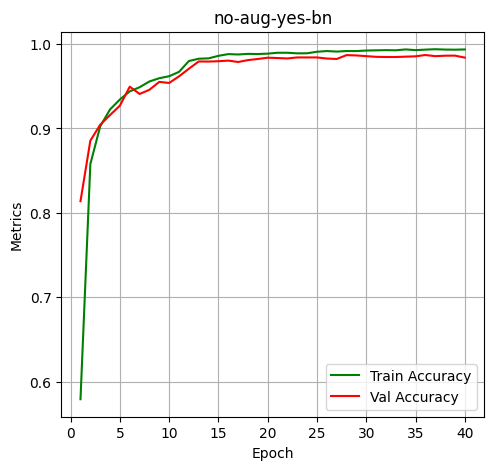

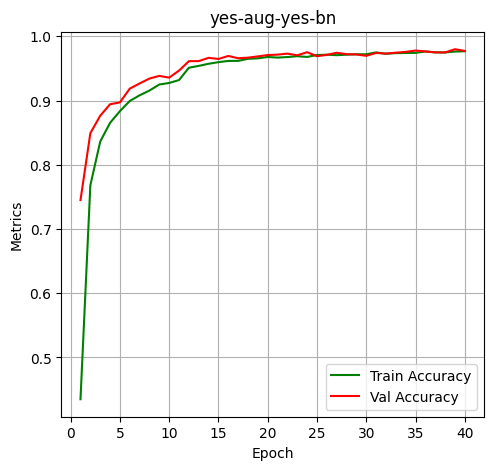

In [ ]:
import os
import dill
import matplotlib.pyplot as plt
from torch_snippets import Glob

def plot_log_metrics(log_data, title="Log"):
    epochs = list(range(1, len(log_data['train_accs']) + 1))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, log_data['train_accs'], label='Train Accuracy', color='green')
    plt.plot(epochs, log_data['val_accs'], label='Val Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title(f'{title}')
    plt.legend()
    plt.grid(True)

for fname in Glob('*.log'):
    with open(fname, 'rb') as f:
        log_data = dill.load(f)

    plot_log_metrics(log_data, title=str(fname).replace('.log', ''))